# Creating Customer Segments

In this project I will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("wholesale-customers.csv")
print ("Dataset has {} rows, {} columns".format(*data.shape))
print (data.head())

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


### Feature Transformation

In [2]:
# Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA

n_components = data.shape[1]
pca = PCA(n_components)
pca.fit_transform(data)

print (pca.components_)
print (pca.explained_variance_ratio_)

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


[[  8.65203357e-07   1.40433954e-07  -7.74134859e-07  -1.11461596e-05
    5.55175206e-07   5.95231239e-06]
 [ -3.97590618e-06   8.59058328e-07   6.24232403e-07   6.77446468e-07
   -2.06101033e-06   1.04342316e-06]
 [ -2.10589800e-07   1.88727663e-06  -6.41843645e-06  -4.12230621e-07
    7.88586022e-07   1.45013212e-06]
 [  3.86436469e-07   2.19531902e-07   6.00815003e-07   5.22057330e-07
   -5.10239101e-07  -1.80925706e-05]
 [  1.53632693e-07   9.84534859e-06  -5.80984571e-06  -3.63864019e-07
    3.31536850e-06  -6.05749699e-06]
 [ -2.99843192e-07   2.30595406e-06   1.20636760e-05  -1.46257243e-06
   -2.82071883e-05  -5.73219911e-06]]


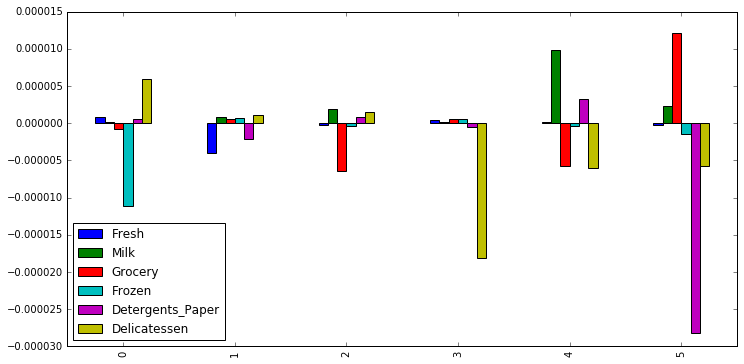

In [3]:
# Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
ica = FastICA(n_components = n_components, random_state = 42, whiten = True).fit(data)

# Print the independent components
print (ica.components_)
pd.DataFrame(ica.components_, columns = data.columns).plot(kind = 'bar', figsize = (12, 6))


The first feature shows an indirect correlation between frozen and delicatessen purchases.  Based on the magnitude of the delicatessen purchases, it's safe to say this feature represents a customer in the shape of a delicatessen that may sell some fine foods, but far less frozen food products.  
The second feature is predominantly made of fresh products.  This component is viewed as one which carries far less fresh products than other items. 
The third feature has one predominant feature, groceries.  This component can be viewed as one that carries far less groceries than any other item.   
The fourth has one predominant feature, delicatessen.  This component can be viewed as one that carries far less delicatessen than any other item.
The fifth feature represents a customer that purchase far more milk than any other item.  
For the sixth feature, there's a strong negative correlation between grocery purchases and detergents_paper products.  So this could represent a customer that purchases more groceries and very little detergents_paper, such as a grocery store or a pharmacy, which purchases some food products but far more paper products. 

Using this data from the ICA, our wholesale distributor now has a better understanding of its customers and is able to target each segment independently.  For example, for customers that purchase more frozen products than delicatessen, it could offer discounts for buying frozen products in bulk.  

In [6]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [7]:
# First we reduce the data to two dimensions using PCA to capture variation

reduced_fit = PCA(2).fit(data)
reduced_data = reduced_fit.transform(data)
print (reduced_data[:10])  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


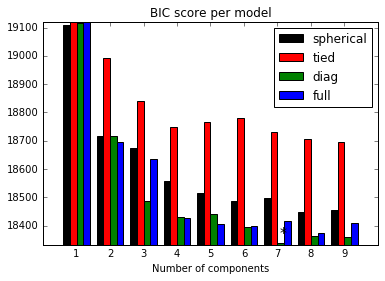

In [8]:
# Perform BIC score to determine the number of clusters

import itertools
import matplotlib as mpl
from scipy import linalg

lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = GMM(n_components=n_components, covariance_type=cv_type)
        gmm.fit(reduced_data)
        bic.append(gmm.bic(reduced_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'g', 'b', 'c', 'm', 'y'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(1, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)



In [9]:
clusters = GMM(n_components = 4)
clusters.fit(reduced_data)
print (clusters)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=4, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


In [10]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [11]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 
centroids = clusters.means_
print(centroids)


[[  2336.74338421  -6721.26945836]
 [ -9418.46902103  34454.41705257]
 [  7182.42527042   5428.27138593]
 [-15313.48033345  -3338.2980532 ]]


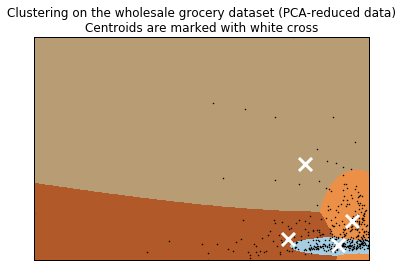

In [12]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

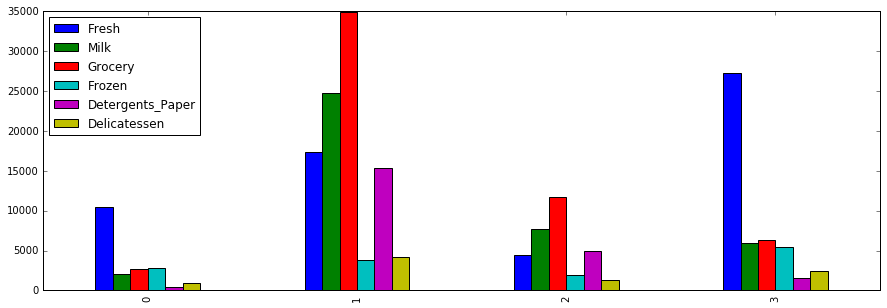

In [13]:
# Bring the centroids into the original dimensions so they can be compared
sample = reduced_fit.inverse_transform(centroids)
pd.DataFrame(sample, columns = data.columns).plot(kind = 'bar', figsize = (15, 5))

I feel the Gaussian Mixture Model was able to give me a better visual representation of the data. It was able to create the cluster colored in brown to wrap tightly around the area where most of the data points were grouped together. This differs from k means in the sense that it included some data points which fell far away from the central objects in the blue cluster; this may not be a great representation or separation of the customers into different segments.

Given that we are able to identify different customer segments, we can use a form of A/B testing, where the wholesaler can test changes it would like to make on different customer segments independently.  For example, if they want to identify how a change in prices may affect customers, they could run a test on a particular customer segment to see the effects before making a general price increase to all their customers.  


For any new customer, we could apply the same approach through feature transformation.  Find the variables or features that stand out and then fit the data to a k-Means model to see which cluster the customer may fall under.  This approach will give us a better understanding of each customer segment and their purchasing habits. 